In [ ]:
import tensorflow_quantum as tfq
import tensorflow as tf
import numpy as np
import scipy.signal as si
import scipy.linalg as la
import sympy
import cirq
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mezze.tfq import *

# Basic workflow
The basic concept behind the Cirq/TensorFlow Quantum enabled SchWARMA simulation revolves around the `cirq.Circuit` class.  These circuits are "SchWARMA-fied" by classes that derive from `SchWARMAFier` that are responsible for both 1) parsing `cirq.Circuit` objects to insert `sympy` symbolic gates (for simulation in Cirq of TensorFlow Quantum) and 2) generate noisy parameter sequences using the underlying ARMA models. The base simulators `CirqSchWARMASim` and `TensorFlowSchWARMASim` take a `Cirq.Circuit` and a `SchWARMAFier` in its constructor and can perform a number of different simulation routines.  For the most part, we focus on `TensorFlowSchWARMASim` as it is faster, but is however limited in the gate set it can simulate. 

SchWARMAFiers can be divided into two main types, base SchWARMAFiers that implement specific targeted errors (along with helper functions such as `psd()` and `corrfn`), and composite SchWARMAFiers that take a list of other SchWARMAFiers and apply them to a common circuit.  This flexible framework allows for the development of complicated error models.

**Base SchWARMAFiers**
* `SimpleDephasingSchWARMAFier`: appends time-correlated errors using a specified operation to each qubit independently.
* `SingleQubitControlSchWARMAFier`: models time-correlated control errors by appending an additional gate only after a specific gate
* `GateQubitDependentSchWARMAFier`: applies a time-correlated, user specfied error after a user specified gate on a user specified qubit(s)
* `NullSchWARMAFier`: SchWARMAFier that applies no errors, used for simulating noise-free circuits

**Composite SchWARMAFiers**
* `AdditiveSchWARMAFier`: takes a list of SchWARMAFiers and adds up their symbolic arguments. Assumes that all of the constituent SchWARMAFiers interact with the circuit in the same way (i.e., their symbolic noisy circuits are all identical). Useful for defining complex power spectra or modeling injected and background noise.
* `SequentialSchWARMAFier`: takes a list of SchWARMAFiers and applies them sequentially to each moment in the circuit.

**Future SchWARMAFiers**
In the nearish future, we intend to implement spatial correlations, two qubit control errors (altough this can be hacked using `GateQubitDependentSchWARMAFier`) and additional composite SchWARMAFiers to better handle non-commuting errors

# Example 1: Time correlated $Z$-dephasing noise
`SimpleDephasingSchWARMAFier` is a SchWARMAFier that applies correlated errors (by default $Z(\theta)$, changeable by the `op` argument in the constructor) after each gate on each qubit. The errors are gate and qubit independent.

In [ ]:
# Define some schwarma coefficients, for e.g., low-pass noise
b = si.firwin(64, .1)

# Normalize
b = b/la.norm(b)*.1

#Make a SchWARMAFier
S = SimpleDephasingSchWARMAFier(b, [1])

In [ ]:
# Take a look at the power spectrum
w, P = S.psd()

pl.figure()
pl.plot(w, 10*np.log10(P))
pl.ylabel('Power, dB')
pl.xlabel('Normlized Frequency')
pl.show()

In [ ]:
# Create a circuit -- here a random one
circ = cirq.generate_boixo_2018_supremacy_circuits_v2_grid(2,2,
                                    4,np.random.randint(2**16))
circ

The noisy, SchWARMAFied circuit can be viewed using `schwarmafy` (note the second argument is the array of symbolic variables). **Note the ordering of the symbolic variables can vary spatially across qubits, but should be sequential in time**.

In [ ]:
noisy_circ, h_array = S.schwarmafy(circ)
noisy_circ

If, for some reason you want to see some noisy tracjectories, these are returned by `gen_noise_instances`. **Note this returns an array where each row is the noise for one circuit.**

In [ ]:
noise = S.gen_noise_instances(circ,1)
noise = np.reshape(noise, (len(circ.all_qubits()),len(circ)))
pl.figure()
pl.plot(noise.T,'-o')
pl.ylabel('Rotation Angle')
pl.xlabel('Gate #')
pl.title('Some Time-Correlated $Z$-rotations')
pl.show()

In [ ]:
# Set up a simulation from a circuit and a schwarmafier and monte carlo simulate
sim = TensorFlowSchWARMASim(circ,S)
avg_density_matrix = sim.dm_sim(num_MC=1000)

In [ ]:
# Now Plot
fig, ax = pl.subplots(1,2,figsize=(10,5))
vv = np.max(np.abs(avg_density_matrix))
pl.set_cmap('bwr')
m1 = ax[0].matshow(np.real(avg_density_matrix),vmin=-vv,vmax=vv)
ax[1].matshow(np.imag(avg_density_matrix),vmin=-vv,vmax=vv)
ax[0].set_title('Real Part of Density Matrix')
ax[1].set_title('Imaginary Part of Density Matrix')
cb_ax = inset_axes(ax[1], width='200%', height='10%', loc='lower center', 
                   bbox_to_anchor=(-.6,-.23,1,1),bbox_transform=ax[1].transAxes,borderpad=0)
cb = fig.colorbar(m1,cax = cb_ax, orientation = 'horizontal')
cb_ax.tick_params(labelsize=12)
pl.show()

# Example 2: Multi-component time correlated $Z$-dephasing noise
Using the class `AdditiveSchWARMAFier` we can simulate more complex noise spectra, such as those withe multiple peaks or a signal with a background noise. 


In [ ]:
# The low pass part
b = si.firwin(64, .1)
b = b/la.norm(b)*.1
S_lp = SimpleDephasingSchWARMAFier(b, [1])

# Add a higher frequency "feature"
b = si.firwin(256, [.3,.31],pass_zero='bandpass')
b = b/la.norm(b)*.025
S_feat = SimpleDephasingSchWARMAFier(b,[1])

# Add a white background noise -- raises the "noise floor"
S_bg = SimpleDephasingSchWARMAFier([.02],[1])

S_tot = AdditiveSchWARMAFier([S_lp, S_feat, S_bg])

w,P = S_tot.psd()
pl.figure()
pl.plot(w, 10*np.log10(P))
pl.ylabel('Power, dB')
pl.xlabel('Normlized Frequency')
pl.show()

In [ ]:
# Simulate and compute fidelity
sim = TensorFlowSchWARMASim(circ, NullSchWARMAFier())
no_noise_dm = sim.dm_sim(1)

sim = TensorFlowSchWARMASim(circ, S_tot)
noise_dm = sim.dm_sim(100)

print('Fidelity: {0}'.format(np.real(np.trace(no_noise_dm@noise_dm))))

# Example 3: Single-qubit multiplicative control noise
`SingleQubitControlSchWARMAFier` can be used to model multiplicative control noise, e.g. $X(\theta)\to X((1+\eta_k)\theta)$ for some ARMA generated noise process $\eta$. 

In [ ]:
#Set up a circuit with various flavors of X and Y gates
q0 = cirq.GridQubit(0,0)
q1 = cirq.GridQubit(1,0)
circ = cirq.Circuit([cirq.rx(1).on(q0),cirq.X(q1)**.5,cirq.ry(1).on(q0),cirq.ry(3).on(q1),cirq.X(q0), cirq.Y(q1)**.25])
circ

In [ ]:
# Define a list of gates to add control errors to.  This one is for X rotations
# XPowGate covers most X rotations, PauliX is for the literal cirq.X() without an exponent
op_list = [cirq.ops.common_gates.XPowGate, cirq.ops.pauli_gates._PauliX]      
    
S = SingleQubitControlSchWARMAFier([.1],[1],op_list, cirq_gate_multiplicative)
noisy_circ, h_array = S.schwarmafy(circ)
print('Note Errors Only after X-rotations:')
noisy_circ

In [ ]:
# Now, add Y rotations into the mix (as in I/Q based control)
op_list += [cirq.ops.common_gates.YPowGate, cirq.ops.pauli_gates._PauliY]
S = SingleQubitControlSchWARMAFier([.1],[1],op_list, cirq_gate_multiplicative)
noisy_circ, h_array = S.schwarmafy(circ)
print('Now Errors after all X and Y rotations:')
noisy_circ

# Example 4: Custom multi-qubit gate SchWARMAFier

Implements the exact QAOA grover from https://doi.org/10.1103/PhysRevA.95.062317

Grover search implemented using QAOA:

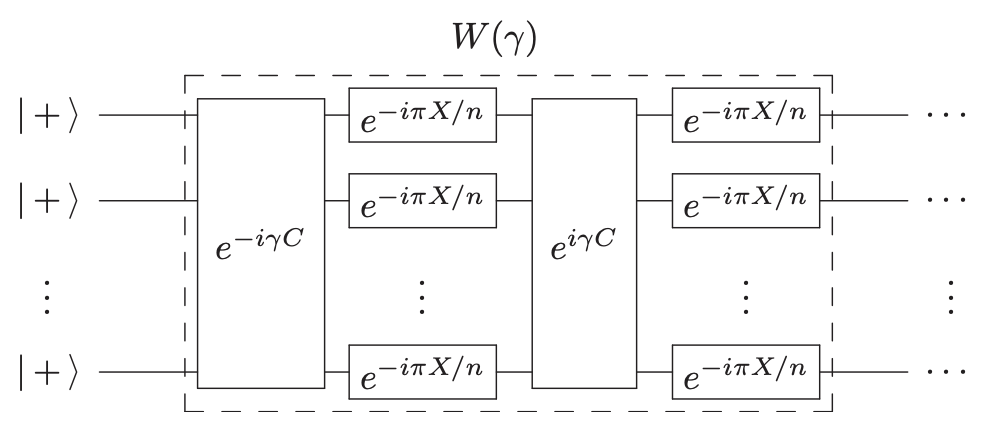

$\gamma =\pi$, $\beta=\pi/n$
$$C=|0\cdots0\rangle\langle 0\cdots 0|$$

For a $p$ layer QAOA anatz, $W$ is applied $p$ times

In this example, we will add independent multiplicative control errors to the multi-qubit projection operator, and the single qubit $X$ gates

## Define the custom gate
Here, we use `cirq.Eigengate` to define a the $e^{i\gamma C}$ gate.  Note this is basically a minimal example showing how to implement QAOA style gates in a `cirq` parameter resolved compatible way.

In [ ]:
class RP0Gate(cirq.EigenGate):
    
    def __init__(self, exponent, Nq):
        
        super().__init__(exponent=exponent)
        self.Nq=Nq
        
    def _eigen_components(self):
        
        eig = np.zeros((2**self.Nq,2**self.Nq))
        eig[0,0] = 1
        
        eigs = [(1/np.pi,eig)]
    
        for j in range(1,2**self.Nq):
            eig = np.zeros((2**self.Nq,2**self.Nq))
            eig[j,j] = 1
            eigs.append((0,eig))
        
        return eigs
    
    def _num_qubits_(self):
        return self.Nq
    
    def _with_exponent(self, exponent):
        return type(self)(exponent=exponent, Nq=self.Nq)
    
    def _circuit_diagram_info_(self, args):
        #return [f"RP0({self.α:0.2f})"]* self.num_qubits()
        try:
            return ["RP0({0:0.2f})".format(self._exponent)]* self.num_qubits()
        except TypeError:
            return ["RP0(err)"]*self.num_qubits()

## Some helper code to acually make the QAOA ciruit

In [ ]:
def grover_circuit_nomeasure(qubits,betas,gammas):
    '''
    betas and gammas are arrays of length P (the number of layers)
    '''
    return cirq.Circuit(
        # Prepare uniform superposition
        cirq.H.on_each(*qubits),
        # Apply QAOA unitary
        grover_Unitary(qubits, betas, gammas))

def grover_Unitary(qubits, betas, gammas):
    num_qubits=len(qubits)
    for beta, gamma in zip(betas, gammas):
        yield RP0Gate(-gamma,Nq=num_qubits).on(*qubits) 
        yield cirq.rx(2*beta).on_each(*qubits)
        yield RP0Gate(gamma,Nq=num_qubits).on(*qubits) 
        yield cirq.rx(2*beta).on_each(*qubits)
        
def groverqaoa(n,p,betas=None,gammas=None,outputflag=False):
    '''
    Calculates |ψ>=U_QAOA |++..+>, and returns |<00...00|ψ>|^2
    '''
    qubits = cirq.LineQubit.range(n)
    if betas==None:
        betas = [np.pi/n]*p
    if gammas==None:
        gammas = [np.pi]*p
    assert len(betas)==p,'Length of betas should be the same as p'
    assert len(gammas)==p,'Length of gammas should be the same as p'
    circuit = grover_circuit_nomeasure(qubits, betas, gammas)
    if outputflag:
    # Print an circuit
        print('Grover QAOA circuit:')
        print(circuit.to_text_diagram(transpose=True))
    simulator = cirq.Simulator()
    results=simulator.simulate(circuit)
    return np.abs(results.final_state_vector[0])**2 

## Grover example
Example of running a grover qaoa circuit and measure the expecation value of the cost function.
Te output state is:
\begin{align}
|\psi_{\rm out}\rangle & =\prod_{i=1}^p\left[ e^{-i\beta \sum_j X_j} e^{i\gamma C} e^{-i\beta \sum_j X_j} e^{-i\gamma C}\right] |+\rangle^{\otimes n}\\
&=\left[\prod_{i=1}^p RX[2\beta]^{\otimes n} RP_0[-\gamma] RX[2\beta]^{\otimes n} RP_0[\gamma]\right] H^{\otimes n}|0\cdots 0\rangle
\end{align}
The output expecation value is:
\begin{align}
\langle C\rangle =-|\langle 0\cdots 0|\psi_{\rm out}\rangle|^2
\end{align}

In [ ]:
#Make a Grover QAOA circuit
qubits = [cirq.GridQubit(i,0) for i in range(6)]
circ = grover_circuit_nomeasure(qubits,[np.pi/6]*3,[np.pi]*3)
circ

In [ ]:
# Since we are SchWARMAFying a custom gate, we need a custom error generator
def RP0_error_gen_mult(op, h):
    return RP0Gate(op.gate._exponent*h,len(op.qubits)).on(*op.qubits)

#Make a SchWARMAFier for the RP0 gate
S_RP0 = GateQubitDependentSchWARMAFier([.1],[1],RP0Gate, qubits, RP0_error_gen_mult)

# Now make one for the X gate, note we need to change the symbol name
op_list = [cirq.ops.common_gates.XPowGate, cirq.ops.pauli_gates._PauliX]          
S_X = SingleQubitControlSchWARMAFier([.1],[1],op_list, cirq_gate_multiplicative,sym='g')

In [ ]:
S_tot = SequentialSchWARMAFier([S_RP0,S_X])
#S_tot = SequentialSchWARMAFier([S_X,S_RP0])

noisy_circ, h_array = S_tot.schwarmafy(circ)
noisy_circ

### Note, since we have a custom gate we can't use TensorFlow (at this time)

In [ ]:
#Since this has a custom gate, can't use tfq for sim
sim = CirqSchWARMASim(circ, NullSchWARMAFier())
density_matrix = sim.dm_sim(num_MC=1)

In [ ]:
sim = CirqSchWARMASim(circ, S_RP0)
noisy_density_matrix = sim.dm_sim(num_MC=10) #definitely increase this if you want a real answer
print('Fidelity: {0}'.format(np.real(np.trace(density_matrix@noisy_density_matrix))))

# Example 5: Basic Spatial Correlations
In this example we will show how to use `MatrixCorrelatorSchWARMAFier` to do basic correlations.  This `SchWARMAFier` takes another `SchWARMAFier` and a matrix.  We will take the circuit from the previous example and add dephasing and X control and show how they can be correlated.  This multiplies the individual error streams (i.e., underlying ARMA model) of the SchWARMAFier by that matrix to correlate them, effectively making each error stream a linear combination of the others.

__Note: Here we use a matrix that averages the errors spatially, so that they are all identical for illustrative purposes.  Practically, one would want to use the matrix square root of the desired correlation matrix.__

In [ ]:
qubits = [cirq.GridQubit(i,0) for i in range(6)]
circ = grover_circuit_nomeasure(qubits,[np.pi/6]*3,[np.pi]*3)
circ

In [ ]:
# Make a temporally correlated 
S_Z = SimpleDephasingSchWARMAFier(b,[1])

# Now make one for the X gate, note we need to change the symbol name
op_list = [cirq.ops.common_gates.XPowGate, cirq.ops.pauli_gates._PauliX]          
S_X = SingleQubitControlSchWARMAFier(b,[1],op_list, cirq_gate_multiplicative,sym='g')

## Method 1: Correlate Individual SchWARMAFiers
We will use matrix correlators to induce perfect correlations on the two types of noise individually.  Note that for each moment the introduced errors are all the same, but the $Z$ and $X$ errors are different.

In [ ]:
A = np.ones((len(qubits),len(qubits)))/len(qubits)
S_Z_corr = MatrixCorrelatorSchWARMAFier(S_Z, A)
S_X_corr = MatrixCorrelatorSchWARMAFier(S_X, A)

# More readable if control error is before dephasing
S_tot = SequentialSchWARMAFier([S_X_corr,S_Z_corr])
S_tot.gen_noisy_circuit(circ,1)

# Method 2: Individually Correlate SchWARMAFiers in a Sequential SchWARMAFier
`MatrixCorrelator` works on `SequentialSchWARMAFier` too, so a block diagonal matrix (of appropriate dimension) will correlate as desired

In [ ]:
Atot = la.block_diag(A,A)
S_tot = SequentialSchWARMAFier([S_X, S_Z])
S_tot_corr = MatrixCorrelatorSchWARMAFier(S_tot,Atot)
S_tot_corr.gen_noisy_circuit(circ,1)

# Method 3: Correlate Error between errors in a Sequential SchWARMAFier
In this example, the $Z$ and $X$ errors on after the `Rx` gates will be the same (don't forget to multiply by $\pi$ for the $X$ error).

__Note: There are slight differences between the Z and X errors, probably due to some numerical issues in their generation (dephasing vs control error).  If the X is replaced with another dephasing error, this issue goes awat.  Will sort this out in the future, but seems like a pathological case, anyway__

In [ ]:
Atot = np.block([[A,A],[A,A]])/2

#S_Z2 = SimpleDephasingSchWARMAFier(b,[1],sym='g')
S_tot = SequentialSchWARMAFier([S_X, S_Z])
S_tot_corr = MatrixCorrelatorSchWARMAFier(S_tot,Atot)
noisy_circ = S_tot_corr.gen_noisy_circuit(circ,1)
#Print out a chunk to make the point
noisy_circ[4:7]

In [ ]:
#See the sight difference...
print(list(noisy_circ[5])[0].gate.exponent)
print(list(noisy_circ[6])[0].gate.exponent)

# Method 4: Correlate Error between qubits in a Sequential SchWARMAFier
In this example, the $Z$ and $X$ errors on after the `Rx` gates will be the same (don't forget to multiply by $\pi$ for the $X$ error), but qubits will have different errors.

In [ ]:
I = np.eye(len(qubits))
Atot = np.block([[I,I],[I,I]])/2
S_tot_corr = MatrixCorrelatorSchWARMAFier(S_tot,Atot)
noisy_circ = S_tot_corr.gen_noisy_circuit(circ,1)
# Print out a chunk to make the point
noisy_circ[4:7]